# CSC311 Lab 2: Decision Trees and Accuracy-based Diagnostics

All artificial intelligence systems have the potential to fail and in some domains
(like health) failures can have grave consequences.  When we work in these domains,
it's important for us to understand our algorithmic errors and their potential risk.

<!--
In labs 2, 5 and 7, we'll loosely be following the autiding procedure suggested by [Lui et. al](https://www.thelancet.com/journals/landig/article/PIIS2589-7500(22)00003-6/fulltext) in order to build and analyze a decision making system that operates in a high risk domain.
-->

In labs 2, 5 and 7, we will use data from The National Health and Nutrition Examination Survey [NHANES](https://www.cdc.gov/nchs/nhanes/index.htm) in the United States.
This survey runs annually to assess people's health and nutritional status, and it combines data from interviews and physical examinations. We will be exploring a
handful of attributes from the 2014 instance of this survey and their ability to predict heart disease.
Making decisions using health data is particularly high risk, so we will use this opportunity to discuss
how to assess our model prior to using it.

<!--
We will then do some testing according to
the [auditing recipe](https://www.thelancet.com/journals/landig/article/PIIS2589-7500(22)00003-6/fulltext#seccestitle40) presented by Liu.
-->

In this lab, we will explore the features in this data set, use `sklearn` to fit a
decision tree to our data, and do some work to select hyperparamters that maximize
accuracy (or minimize the number of our classification mistakes). In future labs, we
will be exploring our mistakes, relating them to important subgroups, and reflecting
on our model's robustness. We will also consider how assessments of risk associated
with our errors should or could inform our decision making criteria.

By the end of this lab, you will be able to:

1. Perform an exploratory analysis to understand the features that we use to make predictions.
2. Transform features into formats amenable to machine learning (i.e. using one-hot embeddings).
3. Use `sklearn` to fit a decision tree to our data and determine its training/validation/test accuracy.
4. Visualize, understand and interpret a decision tree diagram.
5. Explain how various hyperparameter choices may cause our decision tree to underfit or overfit data.
6. Perform hyperparameter tuning to search for the optimal hyperparameters of a decision tree.

Please work in groups of 1-2 during the labs.

Acknowledgements:

- Thanks to https://www.kaggle.com/code/tobyanderson/health-survey-analysis for some utilities to decode NHANES categories!  
- This lab was created in collaboration with, Prof. Sonya Allin, Mustafa Haiderbhai, Carolyn Quinlan, Brandon Jaipersaud and others.

## Submission

If you are working with a partner, start by creating a group on Markus. If you are working alone,
click "Working Alone".

Submit the ipynb file `lab02.ipynb` on Markus
**containing all your solutions to the Graded Tasks**.
Your notebook file must contain your code **and outputs** where applicable,
including printed lines and images.
Your TA will not run your code for the purpose of grading.

For this lab, you should submit the following:


- Part 1. Your explanation for whether our features are likely to be informative predictors. (1 point)
- Part 1. Your explanation for why encoding categorical variables as numeric values is problematic for a decision tree. (1 point)
- Part 1. Your explanation as to why there is no need to normalize the features of a decision tree. (1 point)
- Part 2. Your classification of `X_train[5]` based on your generated decision tree diagram and a justification for your classification. (1 point)
- Part 2. The values of `max_depth` you chose to make your decision tree underfit/overfit, along with the generated diagrams. A justification as to why those values make the tree underfit/overfit. (1 point)
- Part 2. The values of `min_samples_split` you chose to make your decision tree underfit/overfit. A justification as to why those values make the tree underfit/overfit. (1 point)
- Part 3. Your implementation of `build_all_models`.  (2 points)
- Part 3. Your implementation of grid search, including print statement(s) that show your best parameters and corresponding scores for both `entropy` and `gini` criteria.  (1 point)
- Part 4. Your reflections on the exercise, and our definition of a model that performs "well". (1 point)

## Google Colab Setup

As before, we will import `matplotlib` and `numpy` for plotting and linear algebra
manipulations.

In [ ]:
import matplotlib.pyplot as plt # For plotting
import numpy as np              # Linear algebra library

In addition to using `numpy` for its linear algebra functionalities, we will also use
a library called `pandas` to help us read CSV files and manipulate tabular data.
The below code reads each of the csv files into a **data frame**, which is a way that
`pandas` stores tabular data.
As an added bonus, Jupyter notebooks display these data frames in a human-readable way.

In [ ]:
import pandas as pd

As before, we will start by downloading the data to Google Colab.

In [ ]:
!wget https://www.cs.toronto.edu/~lczhang/311/lab02/NHANES-heart.csv

--2025-09-12 04:26:03--  https://www.cs.toronto.edu/~lczhang/311/lab02/NHANES-heart.csv
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 450659 (440K) [text/csv]
Saving to: ‘NHANES-heart.csv’

NHANES-heart.csv    100%[===================>] 440.10K  1.39MB/s    in 0.3s    

2025-09-12 04:26:03 (1.39 MB/s) - ‘NHANES-heart.csv’ saved [450659/450659]



Use pandas to read the dataset.

In [ ]:
# read each of the csv files as a *pandas data frame*
data = pd.read_csv("NHANES-heart.csv")

# display one the dataframes in the notebook
data

,gender,race_ethnicity,chest_pain_ever,drink_alcohol,age,BMI,weight_kg,blood_pressure_sys,diastolic_bp,blood_cholesterol,calories,family_income,target_heart
0,1,4,1.0,1.0,62,29.1,77.3,104.0,56.0,5.64,815.0,0.87,0.0
1,1,6,2.0,1.0,50,20.9,42.9,118.0,46.0,5.25,2339.0,3.63,0.0
2,2,1,2.0,2.0,62,16.6,27.3,116.0,66.0,3.23,1405.0,3.09,0.0
3,1,3,2.0,1.0,61,17.6,26.2,90.0,52.0,3.67,1735.0,2.13,0.0
4,1,4,2.0,1.0,69,13.5,21.0,116.0,66.0,4.50,1735.0,1.74,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,2,3,1.0,2.0,76,24.6,13.1,116.0,66.0,4.50,1735.0,2.05,1.0
7996,2,2,2.0,2.0,43,29.0,81.4,134.0,62.0,3.05,1735.0,0.45,1.0
7997,1,6,2.0,2.0,51,14.3,15.6,116.0,66.0,4.50,1735.0,0.48,1.0
7998,1,2,1.0,1.0,64,24.6,11.6,116.0,66.0,4.50,1120.0,0.31,1.0


## Part 1. Data

We will be focusing on NHANES survey data relevant to the assessment of heart disease.
Note however that assessing the presence of heart disease based on this survey data is not an easy task.
This is because people may have heart disease but not know it, or people may think they have heart disease
when they do not. In our data, we have defined an individual as having heart disease if they answered "Yes"
to this question on the NHANES survey: "Have you ever been told by a doctor that you had congestive heart
failure, coronary heart disease, a heart attack, or a stroke?".  This is, as you may notice, not the perfect
measure of heart disease! It is however the information we have in hand and it is consistent with the way others
have defined heart disease in the [literature](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6836338/).

If you are interested in better understanding the NHANES survey responses, we encourage you to look at
the [NHANES data dictionary](https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx). Understanding
your data is extremely important, as there are often situations in which measurements may be ambiguous or
inaccurate, and these inaccuracies impact any decision making algorithm you create.

If you do work to gather data, it will be your responsibility to document this data.  And if you use data to
create an algorithm, it will be your responsibility to understand its limitations.  If you are interested in
best practices related to data documentation, we encourage you to read [Gebru's article on this topic](https://arxiv.org/pdf/1803.09010.pdf).
You may also be interested in current data [reporting standards](https://www.bmj.com/content/370/bmj.m3164) for clinical trials that involve automated decision making tools.

In this lab, we will be looking at 10 features from the NHANES data set. We have done work to clean the data for you so that it is approachable, but we encourage you to take a look at the raw data as you are able.  The definitions of the features are as follows:

- `gender` (RIAGENDR): which is binary 2=female, 1=male
- `race_ethnicity` (RIDRETH3): which can be 1=mexican american, 2=other hispanic, 3=white, 4=black, 6=asian, ...
- `age` (RIDAGEYR): Age in years
- `drink_alcohol` (ALQ101): which is binary; 1 indicates the individual reportedly drinks alcohol and 2 indicates they do not
- `blood_cholesterol` (LBDTCSI): Results of an individual's blood cholesterol tests (mmol of cholesterol/L of blood)
- `blood_pressure_sys` (BPXSY1): an individual's systolic blood pressure
- `diastolic_bp` (BPXDI1): an individual's diastolic blood pressure
- `calories` (DR1TKCAL): the number of calories an individual eats per day
- `BMI` (BMXBMI): an individual's Body Mass Index (which can be used to assess obesity)
- `chest_pain_ever` (CDQ001): If an individual has ever reported chest pain.
- `family_income` (INDFMPIR): Ratio of a family's income to poverty threshold

We will be using these features to predict the column `target_heart`:

- `target_heart`: An individual reports that they have heart disease (1=yes, 0=no).


Let's start by exploring the data that we have in hand. Pandas has a nice function to summarize the mean and dispersion of each feature in our data frame:

In [ ]:
data.describe()

,gender,race_ethnicity,chest_pain_ever,drink_alcohol,age,BMI,weight_kg,blood_pressure_sys,diastolic_bp,blood_cholesterol,calories,family_income,target_heart
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,1.498375,3.222000,1.649125,1.304375,62.627875,25.352687,61.112887,117.135500,65.705000,4.584376,1866.986875,2.456017,0.500000
std,0.500029,1.330672,0.477274,0.460171,12.225806,7.683466,32.803242,15.050115,11.610893,0.908403,867.494312,1.532800,0.500031
min,1.000000,1.000000,1.000000,1.000000,40.000000,12.900000,3.300000,82.000000,0.000000,2.020000,171.000000,0.000000,0.000000
25%,1.000000,3.000000,1.000000,1.000000,52.000000,19.700000,33.600000,108.000000,60.000000,4.090000,1337.750000,1.180000,0.000000
50%,1.000000,3.000000,2.000000,1.000000,63.000000,24.600000,63.700000,116.000000,66.000000,4.500000,1735.000000,2.050000,0.500000
75%,2.000000,4.000000,2.000000,2.000000,73.000000,29.500000,83.000000,122.000000,72.000000,4.970000,2215.250000,3.800000,1.000000
max,2.000000,7.000000,2.000000,2.000000,80.000000,82.900000,201.600000,220.000000,116.000000,11.970000,8496.000000,5.000000,1.000000


We can also visualize the spread of numerical features using *box plots*. A box plot visually summarizes much of the information that is produced by a call to data.describe(). The orange line in the middle of each box represents the median (or 50th percentile) of the data.  Each box spans a range from the 25th to 75th percentile of the attribute in question. Outliers are plotted as points outside of the box.

If, after you review some box plots, you are not comfortable with how box plots work, [Khan Academy has a good series of videos that explain how to read and interpret them.](https://www.khanacademy.org/math/statistics-probability/summarizing-quantitative-data/box-whisker-plots/v/reading-box-and-whisker-plots)

{'whiskers': [<matplotlib.lines.Line2D at 0x7b824f4fe5a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7b824f4feab0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7b824f4abaa0>],
 'medians': [<matplotlib.lines.Line2D at 0x7b824f4ff110>],
 'fliers': [<matplotlib.lines.Line2D at 0x7b824f4ff410>],
 'means': []}

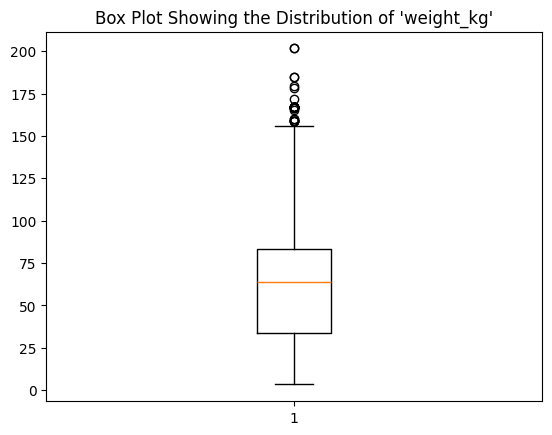

In [ ]:
plt.title("Box Plot Showing the Distribution of 'weight_kg'")
plt.boxplot(data["weight_kg"])

{'whiskers': [<matplotlib.lines.Line2D at 0x7b824d173860>,
 'caps': [<matplotlib.lines.Line2D at 0x7b824d173ef0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7b824d173590>],
 'medians': [<matplotlib.lines.Line2D at 0x7b824d18c590>],
 'fliers': [<matplotlib.lines.Line2D at 0x7b824d18c8c0>],
 'means': []}

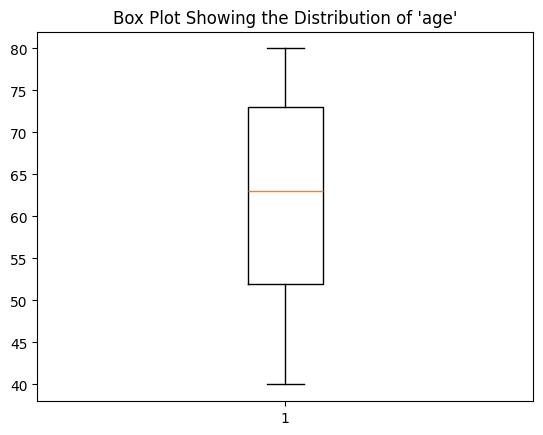

In [ ]:
plt.title("Box Plot Showing the Distribution of 'age'")
plt.boxplot(data["age"])

In the first box plot, we see that half of the people in the data set are under 64 kg,
just as shown in the table generated by `data.describe()`. We see also that there are some outliers who weigh more than the general population of people in our data set.


**Task:** Plot box plots for the remaining numerical features.

{'whiskers': [<matplotlib.lines.Line2D at 0x7b824d1c79b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7b824d1c7fe0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7b824d1c7680>],
 'medians': [<matplotlib.lines.Line2D at 0x7b824d2084a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7b824d2087a0>],
 'means': []}

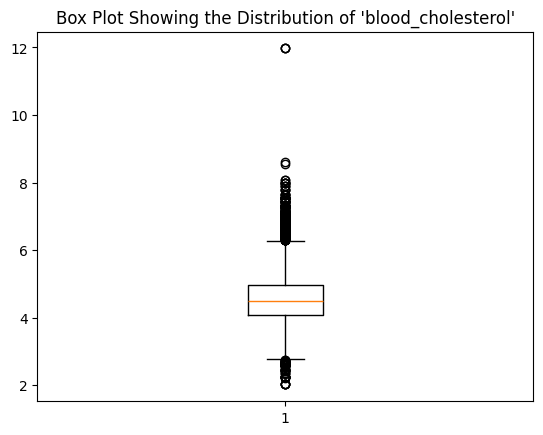

In [ ]:
plt.title("Box Plot Showing the Distribution of 'blood_cholesterol'")
plt.boxplot(data["blood_cholesterol"])

{'whiskers': [<matplotlib.lines.Line2D at 0x7b824d090800>,
 'caps': [<matplotlib.lines.Line2D at 0x7b824d090dd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7b824d090500>],
 'medians': [<matplotlib.lines.Line2D at 0x7b824d0913a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7b824d0916a0>],
 'means': []}

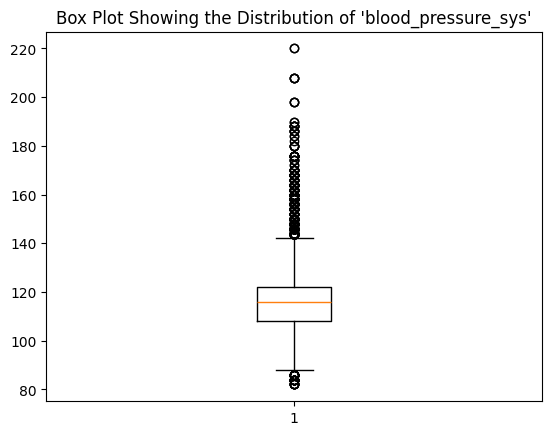

In [ ]:
plt.title("Box Plot Showing the Distribution of 'blood_pressure_sys'")
plt.boxplot(data["blood_pressure_sys"])

{'whiskers': [<matplotlib.lines.Line2D at 0x7b824d219970>,
 'caps': [<matplotlib.lines.Line2D at 0x7b824d108a70>,
 'boxes': [<matplotlib.lines.Line2D at 0x7b824d108380>],
 'medians': [<matplotlib.lines.Line2D at 0x7b824d109040>],
 'fliers': [<matplotlib.lines.Line2D at 0x7b824d109370>],
 'means': []}

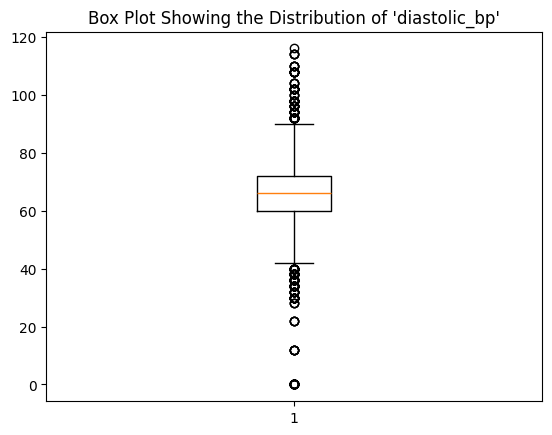

In [ ]:
plt.title("Box Plot Showing the Distribution of 'diastolic_bp'")
plt.boxplot(data["diastolic_bp"])

{'whiskers': [<matplotlib.lines.Line2D at 0x7b824f2ec350>,
 'caps': [<matplotlib.lines.Line2D at 0x7b824f2ec8c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7b824d21f770>],
 'medians': [<matplotlib.lines.Line2D at 0x7b824f2ecec0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7b824f2ed190>],
 'means': []}

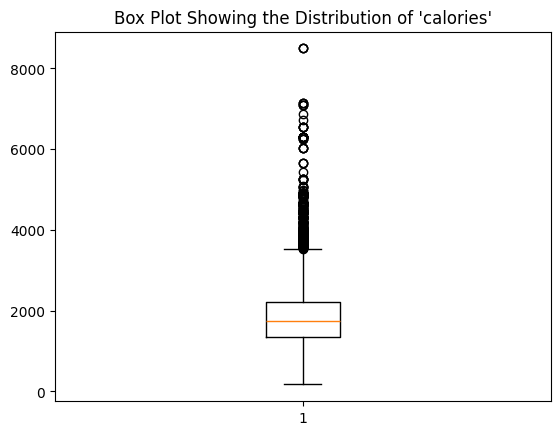

In [ ]:
plt.title("Box Plot Showing the Distribution of 'calories'")
plt.boxplot(data["calories"])

{'whiskers': [<matplotlib.lines.Line2D at 0x7b824f3331a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7b824f3335f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7b824f332f00>],
 'medians': [<matplotlib.lines.Line2D at 0x7b824f333bf0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7b824f333e90>],
 'means': []}

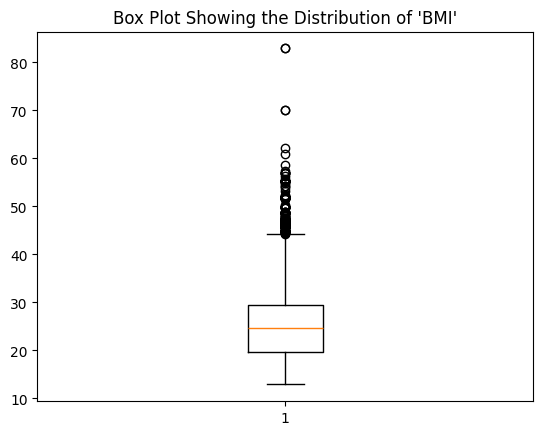

In [ ]:
plt.title("Box Plot Showing the Distribution of 'BMI'")
plt.boxplot(data["BMI"])

{'whiskers': [<matplotlib.lines.Line2D at 0x7b824cf5b530>,
 'caps': [<matplotlib.lines.Line2D at 0x7b824cf5ba70>,
 'boxes': [<matplotlib.lines.Line2D at 0x7b824cf5b260>],
 'medians': [<matplotlib.lines.Line2D at 0x7b824cf5bf80>],
 'fliers': [<matplotlib.lines.Line2D at 0x7b824cf882f0>],
 'means': []}

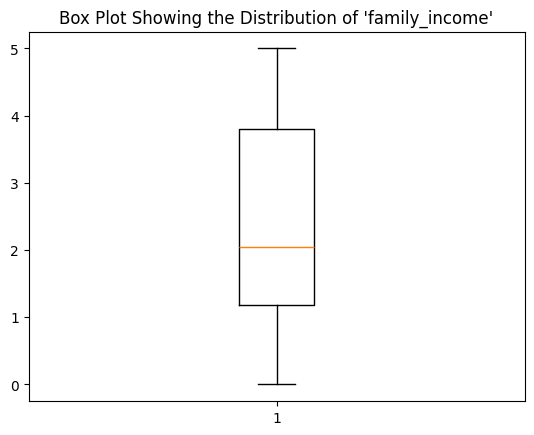

In [ ]:
plt.title("Box Plot Showing the Distribution of 'family_income'")
plt.boxplot(data["family_income"])

For the categorical features, we can also tabulate the frequency that each category
occurs in the data set:

In [ ]:
data['gender'].value_counts()

,count
gender,
1,4013
2,3987


In [ ]:
data['drink_alcohol'].value_counts()

,count
drink_alcohol,
1.0,5565
2.0,2435


In [ ]:
data['chest_pain_ever'].value_counts()

,count
chest_pain_ever,
2.0,5193
1.0,2807


We see there are roughly equal numbers of men and women in the dataset and the majority report they drink alcohol.  About 1 in 4 report that they have experienced chest pain at some point in their lives.

Finally, let's take a look at the distribution of our target variable.

In [ ]:
data['target_heart'].value_counts()

,count
target_heart,
0.0,4000
1.0,4000


Note there are an equal number of cases that are labelled as having heart disease as not having heart disease.  This is both curious and convenient but it is absolutely **NOT** representative of the distribution of heart disease in the general population.  In the general population of Canada, about 1 in 12 (or 8%) have heart disease.  This is roughly the same as the distribution of reported heart disease across all NHANES survey respondents.  So why doesn't the data we are analyzing here reflect this distribution?  This is because we have sampled the NHANES survey data so as to **balance** the cases of heart disease against the cases without.

**Task** Why did we create a dataset with a roughly equal number of data points that have `target_heart=1` and `target_heart=0`? In particular, what do you think might happen to our decision tree if we allowed 92% our training data to reflect the true prevalence of heart disease? <!-- ... and to therefore consist of data points with `target_heart=0`? -->

In [ ]:
# With highly imbalanced data, a decision tree tends to favor the majority class
# and fails to learn the minority class features.
# This leads to high overall accuracy but poor performance on the minority class,
# making the predictions unreliable.

**Task**: Let's continue exploring our data by plotting separate box plots for people with heart disease and people without heart disease. These box plots for (for `blood_cholesterol`, `age`, `calories` and `BMI`) should give you a sense of whether people with heart disease are
different from those without heart disease, according to each of these characteristics. You should see that those with heart disease are, on average, older.

<Axes: title={'center': 'blood_cholesterol'}, xlabel='target_heart'>

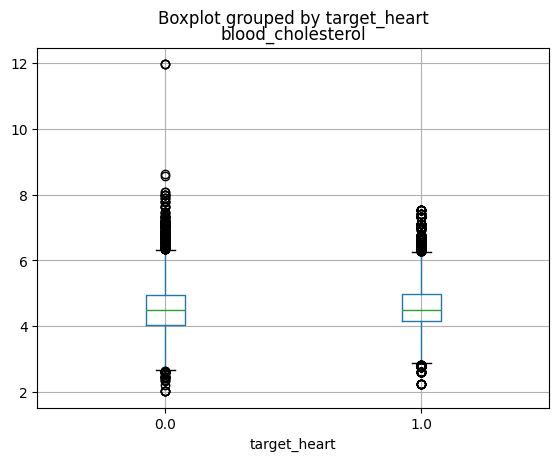

In [ ]:
# analyze the distribution of blood_cholesterol for people with and without heart disease
data.boxplot(column='blood_cholesterol', by='target_heart')

<Axes: title={'center': 'age'}, xlabel='target_heart'>

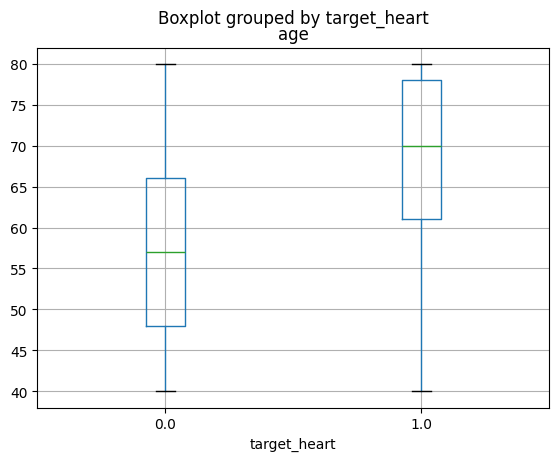

In [ ]:
# analyze the distribution of age for people with and without heart disease
data.boxplot(column='age', by='target_heart')

<Axes: title={'center': 'calories'}, xlabel='target_heart'>

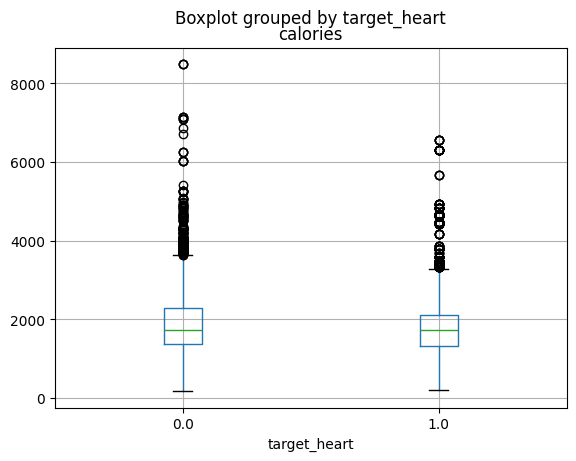

In [ ]:
# analyze the distribution of calories for people with and without heart disease
data.boxplot(column='calories', by='target_heart')

<Axes: title={'center': 'BMI'}, xlabel='target_heart'>

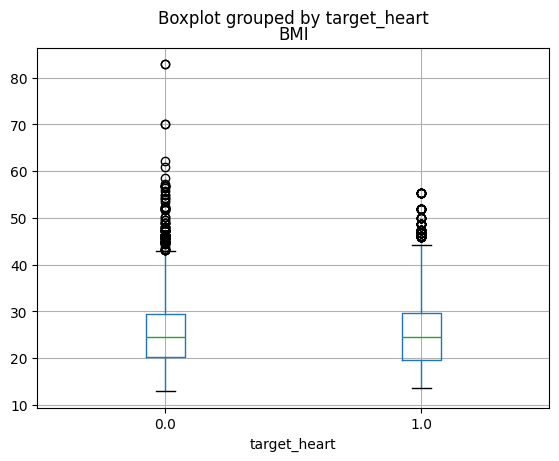

In [ ]:
# analyze the distribution of BMI for people with and without heart disease
data.boxplot(column='BMI', by='target_heart')

**Task**: We will do the same type of exploration for the categorical
variables. Read the documentation for
[pandas.crosstab](https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html)
so that you can explain the results of the following calls:

In [ ]:
pd.crosstab(data["target_heart"], data["gender"])

gender,1,2
target_heart,,
0.0,1819,2181
1.0,2194,1806


In [ ]:
pd.crosstab(data["target_heart"], data["drink_alcohol"])

drink_alcohol,1.0,2.0
target_heart,,
0.0,2824,1176
1.0,2741,1259


In [ ]:
pd.crosstab(data["target_heart"], data["chest_pain_ever"])

chest_pain_ever,1.0,2.0
target_heart,,
0.0,791,3209
1.0,2016,1984


**Graded Task**:
Do you expect each of "blood_cholesterol", "age",  "calories", and "BMI" to be an informative predictor for "target_heart"?
What about "gender", "drink_alcohol" and "chest_pain_ever"?
Using your output from above, briefly explain why or why not.

In [ ]:
# TODO: your prediction as to whether these features are informative predictors.
# For full credit, justify your answer with the figures above. Include the
# figures above in your submission.

**Task**: Complete the exploratory data analysis by visualizing the remaining features.
You should get a sense of whether these features may be informative predictors,
and the distribution of these features.

As a side note, this is also a great time to look for unexpected issues with the data.
Is there missing data? Is there data that is outside the normal range that you would expect
(e.g. an age of 500)? Are there features that almost always take on the same value,
and would therefore likely not to be useful?

In [ ]:
# TODO

**Graded Task**: Before being able to use our data to train a decision tree model,
we need to transform some of the ways that our features are encoded. In particular, we need to change our current encoding of `gender`
and `race_ethnicity`.  Explain why the current encoding should not be used with a decision tree classifier.

In [ ]:
# TODO: your explanation

To solve the problem with our current encoding, we will encode categorical features using
**indicator variables**. We will construct an indicator variable for every possible
*value* or *category*.  More specifically, we will make a separate indicator variable for `race_ethicity_white`,
`race_ethicity_black`, etc, with each feature taking on a value of 1 or 0.

We will also group together `race_ethnicity=1` and
`race_ethnicity=2` since these groups represent "Mexican American" and
"Other Hispanic" and these groups are smaller than the others.
This is a modeling decision born out of our understanding of the data,
**and it may not be the correct decision**!
Typically, many factors would go into decisions like this, including discussions
with colleagues to understand where the data comes from and how the model will be used.
Model building is also an iterative process: we may want to build multiple models with different
feature representations, and compare the performance and other characteristics of
these models.

**Task**: Convert `data` into a numpy array `data_fets` with $N=8000$
rows and with the following columns:

- An indicator feature with value 1 iff `gender=2` (female)
- An indicator feature with value 1 iff `race_ethnicity=1` or `race_ethnicity=2` (hispanic)
- An indicator feature with value 1 iff `race_ethnicity=3` (white)
- An indicator feature with value 1 iff `race_ethnicity=4` (black)
- An indicator feature with value 1 iff `race_ethnicity=6` (asian)
- An indicator feature with value 1 iff `chest_pain_ever=1`
- An indicator feature with value 1 iff `drink_alcohol=1`
- The numerical `age` feature
- The numerical `blood_cholesterol` feature
- The numerical `BMI` feature
- The numerical `blood_pressure_sys` feature
- The numerical `diastolic_bp` feature
- The numerical `calories` feature
- The numerical `family_income` feature

Some of the features are provided for you. Complete the remaining features.

This code works by creating individual numpy (1D) arrays for each feature,
and then stacking them together into a single (2D) numpy array.

In [37]:
data_fets = np.stack([
    # gender_female: this code creates an array of booleans, which converted into 0 and 1
    data["gender"] == 2,
    # re_hispanic: this code leverages addition to perform an "or" operation
    (data["race_ethnicity"] == 1) + (data["race_ethnicity"] == 2),
    # re_white
    data["race_ethnicity"] == 3,
    # re_black
    data["race_ethnicity"] == 4,
    # re_aisan
    data["race_ethnicity"] == 6,
    # chest_pain_ever
    data["chest_pain_ever"] == 1,
    # drink_alcohol
    data["drink_alcohol"] == 1,
    # age: this is a numeric value and no transformations are required
    data["age"],
    # blood_cholesterol: this is a numeric value and no transformations are required
    data["blood_cholesterol"],
    # BMI: this is a numeric value and no transformations are required
    data["BMI"],
    # blood_pressure_sys: this is a numeric value and no transformations are required
    data["blood_pressure_sys"],
    # diastolic_bp: this is a numeric value and no transformations are required
    data["diastolic_bp"],
    # calories: this is a numeric value and no transformations are required
    data["calories"],
    # family_income: this is a numeric value and no transformations are required
    data["family_income"]
], axis=1)

print(data_fets.shape) # Should be (8000, 14)

(8000, 14)


We will also declare a new array to store all the feature names. This will come in handy later when we visualize decision trees.

In [38]:
feature_names = [
    "gender_female",
    "re_hispanic",
    "re_white",
    "re_black",
    "re_asian",
    "chest_pain",
    "drink_alcohol",
    "age",
    "blood_cholesterol",
    "BMI",
    "blood_pressure_sys",
    "diastolic_bp",
    "calories",
    "family_income"]

**Task** Finally, let's separate our data into training, validation, and test sets.
We will use 5000 data points for training, 1500 for validation, and 1500 for test.

Instead of manually splitting the data into two sets, we will use a function provided by `sklearn` which randomly splits the data for us. Use the `train_test_split` function to split the data into training and test sets. To ensure that the randomization is consistent across runs, please supply the following parameter to the `train_test_split` function: 'random_state=1'.  This will ensure that the each time you run your code, you are placing the same data points in your training, test and validation sets.

You will likely need to read the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) for the `sklearn.model_selection.train_test_splits` to get this job done.

In [ ]:

from sklearn.model_selection import train_test_split

# Split the data into X (dependent variables) and t (response variable)
X = data_fets
t = np.array(data["target_heart"])

# First, we will use `train_test_split` to split the data set into
# 6500 training+validation, and 1500 test:
X_tv, X_test, t_tv, t_test = train_test_split(X, t, test_size=1500/8000, random_state=1)

# Then, use `train_test_split` to split the training+validation data
# into 5000 train and 1500 validation

**Graded Task**: Recall that in lab 1, normalizing our features yielded a
marked improvement in the performance (accuracy) of our kNN model.
Explain why normalizing our features will likely *not* improve a
decision tree classifier.

Your explanation serves as justification for *not* normalizing our features before continuing.

In [ ]:
# TODO

## Part 2. Using `sklearn` to Implement and Visualize Decision Trees

One advantage of decision trees over other models is that they are easy
to interpret and visualize.  The function `visualize_tree` below can be used to plot an `sklearn` decision tree model in your Colab Notebook.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# imports to visualize tree
from sklearn import tree as treeViz
import graphviz
import pydotplus
from IPython.display import display

In [ ]:
def visualize_tree(model, max_depth=5):
    """
    Generate and return an image representing an Sklearn decision tree.

    Each node in the visualization represents a node in the decision tree.
    In addition, visualization for each node contains:
        - The feature that is split on
        - The entropy (of the outputs `t`) at the node
        - The number of training samples at the node
        - The number of training samples with true/false values
        - The majority class (heart disease or not)
    The colour of the node also shows the majority class and purity

    See here: https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html

    Parameters:
        `model` - An Sklearn decision tree model
        `max_depth` - Max depth of decision tree to be rendered in the notebook.
         This is useful since the tree can get very large if the max_depth is
         set too high and thus making the resulting figure difficult to interpret.
    """
    dot_data = treeViz.export_graphviz(model,
                                       feature_names=feature_names,
                                       max_depth=max_depth,
                                       class_names=["heart_no", "heart_yes"],
                                       filled=True,
                                       rounded=True)
    return display(graphviz.Source(dot_data))


Next, we will use sklearn's `DecisionTreeClassifier` to create some decision trees to fit to our data.

**Task:** Fit a `DecisionTreeClassifier` to our dataset. Use `entropy` to measure the quality of a decision tree split, and set the `max_depth` to 3. Then, print the training and validation scores (accuracy).

See more here: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [ ]:
# Creating a DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# TODO: fit it to our data

# Print the training and validation scores (accuracy)
print("Training Accuracy:", tree.score(X_train, t_train))
print("Validation Accuracy:", tree.score(X_valid, t_valid))

**Task:** Use `visualize_tree` to visualize the decision tree that was fit.

In [ ]:
# TODO: call visualize_tree on the tree that was fit

If this is done correctly, you should see your decision tree rendered above in your notebook.

Let's try to interpret the decision tree we just generated!

**Graded Task:** Using the decision tree you generated above, classify the training example `X_train[5]` by hand.
In your write up, determine the set of nodes in the decision tree that we must visit to classify this training example.

In [ ]:
# TODO: Perform the classification of this data point by hand
print(dict(zip(feature_names, X_train[5])))

We will now explore some hyperparameter choices that may cause our decision tree to underfit or overfit our data. Recall that overfitting means that, while our model may accurately capture relationships between inputs and our classification target in training data, it may not capture such relationships in the validation data. By contrast, underfitting occurs when our model lacks the complexity to model relationships in either training or validation data.  

**Task:** Similar to what you did above, create another `DecisionTreeClassifier` that uses `entropy` to measure the quality of a split. Set the `max_depth` to a value that will cause the tree to *underfit*. Report the accuracy on the validation and training sets. Visualize the tree by calling `visualize_tree`.

In [ ]:
# TODO: create a DecisionTreeClassifier

# TODO: fit it to our data

# Print the training and validation accuracy
print("Training Accuracy:", tree.score(X_train, t_train))
print("Validation Accuracy:", tree.score(X_valid, t_valid))

# TODO: visualize the tree

**Task:** Repeat the same computation as above, but set the `max_depth` to a value that will cause the tree to *overfit*. When using `visualize_tree` to visualize the tree, leave the default max depth parameter as 5.

In [ ]:
# TODO

**Graded Task:** What value of `max_depth` did you choose to make the tree underfit, or overfit? Why do these values cause the graph to underfit, or overfit?

In [ ]:
# TODO

We will now repeat the same computation as above, but vary the `min_samples_split` parameter instead of `max_depth`.

**Task:** Similar to what we've been doing above, create another `DecisionTreeClassifier` that uses `entropy` to measure the quality of a split. This time set `min_samples_split` to a value that would cause the tree to *underfit*.  Omit the `max_depth` parameter. Report the accuracy (obtained via the `score()` method) on the validation and training sets. Visualize the tree.

In [ ]:
# TODO

**Task:** Repeat the same thing you did above. Set `min_samples_split` to a value that would cause the tree to *overfit*. Omit the `max_depth` parameter. Report the accuracy on the validation and training sets. When using `visualize_tree` to visualize the tree, you can leave the default max depth parameter as 5.

In [ ]:
# TODO

**Graded Task:** What value of `min_samples_split` did you choose to make the tree underfit, or overfit? Why do these values cause the graph to underfit, or overfit?

In [ ]:
# TODO

**Task:** What differences in training accuracy do you see between your underfitted and overfitted decision trees? Why might this be the case?

In [ ]:
# TODO

## Part 3. Hyperparameter Tuning

So far, we have experimented with two Decision Tree hyperparameters: `max_depth` and `min_samples_split`. Another hyperparameter we can vary is the `criterion` for measuring split quality. In lecture, and earlier in this lab, we used `entropy` as the criterion. Another criterion that Sklearn supports is `gini` (Gini impurity index). You don't need to know the implementation details behind this as we'll rely on Sklearn to compute it. However, if you are interested in learning more about this alternative impurity index, we encourage you to [read more about it](https://en.wikipedia.org/wiki/Gini_coefficient).

Thus, our goal is now to figure out what combination of `max_depth`, `min_samples_split` and `criterion` results in the "best" decision tree. It is up to you to determine what "best" means in this context.

**Graded Task:** Start by completing `build_all_models` based on the function specification.
This function builds many trees, one for each combination of hyperparameters, and
then compares them.

In [ ]:
def build_all_models(max_depths,
                     min_samples_split,
                     criterion,
                     X_train=X_train,
                     t_train=t_train,
                     X_valid=X_valid,
                     t_valid=t_valid):
    """
    Parameters:
        `max_depths` - A list of values representing the max_depth values to be
                       try as hyperparameter values
        `min_samples_split` - An list of values representing the min_samples_split
                       values to try as hyperpareameter values
        `criterion` -  A string; either "entropy" or "gini"

    Returns a dictionary, `out`, whose keys are the the hyperparameter choices, and whose values are
    the training and validation accuracies (via the `score()` method).
    In other words, out[(max_depth, min_samples_split)]['val'] = validation score and
                    out[(max_depth, min_samples_split)]['train'] = training score
    For that combination of (max_depth, min_samples_split) hyperparameters.
    """
    out = {}

    for d in max_depths:
        for s in min_samples_split:
            out[(d, s)] = {}
            # Create a DecisionTreeClassifier based on the given hyperparameters and fit it to the data
            tree = None # TODO

            # TODO: store the validation and training scores in the `out` dictionary
            out[(d, s)]['val'] = None # TODO
            out[(d, s)]['train'] = None # TODO
    return out

**Graded Task:** In this task, we will use an approach called **grid search** to
tune hyperparameters: we will list possible values for each hyperparameter,
and then attempt every combination of hyperparameter choices. In our case,
we will start with some possible values for `max_depth`, `min_samples_split` and `criterion`. Then we will try all combinations
of these hyperparameter choices.

Complete the code below that performs grid search, by using `build_all_models`
to build models and evaluate hyperparameter choices.
Print the best parameters and corresponding scores (accuracy) for each of
criterion=entropy and criterion=gini (i.e. you should have 2 print statements, 1 for each criterion).

In [ ]:
# Hyperparameters values to try in our grid search
criterions = ["entropy", "gini"]
max_depths = [1, 5, 10, 15, 20, 25, 30, 50, 100]
min_samples_split = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

for criterion in criterions:
    print("\nUsing criterion {}".format(criterion))
    res = None # TODO: call `build_all_models` for the given hyperparameters

    # TODO: complete this loop which should search for the optimal
    #  (max_depth, min_samples_split) given this criterion
    for d, s in res:
        pass # TODO


## Part 4. Test accuracy

**Task:** Use the optimal set of hyperparameters you previously discovered to fit a new Decision Tree model to the data. Report the test score.

In [ ]:
best_tree = None # TODO

The accuracy measure above considers every mis-classification that is made by our model an `error`, and it assumes that each and every error is of equal importance. However, in many domains, not all errors are of equal importance at all! Some mistakes may have significant negative impacts on people, while others may not.  In future labs, we'll look more closely at different kinds of errors that our models may make and reflect on how these errors might be related to risks.

For now, however, let's simply reflect on some shortcomings of the accuracy measure above.

**Graded Task:** Assume we have two decision trees that both report 95% accuracy on our validation set.
Why might a doctor prefer to use one tree rather than the other?  Answer below in 100 words or less.

In [ ]:
# TODO